# Pima Indians Diabetes Classification
The purpose of this project is to become more familiar with both scikit classfier tools and different types of plots.
The data set is comprised of 8 numeric health measures and a single output with 1 coded as "tested positive for diabetes" and 0 coded as "tested negative for diabetes." The attributes are as follows:
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function (based on family history)
   8. Age (years)
   9. Class variable (0 or 1)
I will test various SVM classifiers, a Ridge classifier, logistic regression, and a neural net to analyze the data.
## Import and visualize data

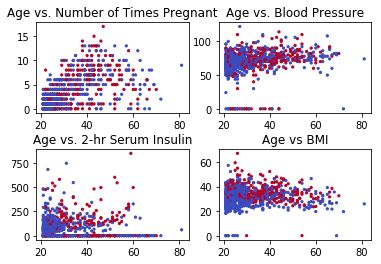

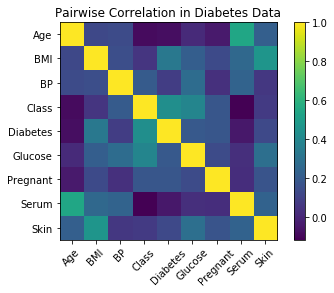

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd


data = pd.read_excel(r'C:/Users/Will/Desktop/Projects/Pima_Diabetes.xls')
data1  = np.asarray(data)
Y  = np.asarray(data['Class'])
Pregnant = np.asarray(data['Pregnant'])
BP = np.asarray(data['BP'])
Serum = np.asarray(data['Serum'])
BMI = np.asarray(data['BMI'])
Age = np.asarray(data['Age'])


##769 samples
##lets first make some plots that show what were working with.
fig, sub = plt.subplots(2,2 )
plt.subplots_adjust(wspace=.2, hspace=0.4)
titles = ('Age vs. Number of Times Pregnant', 'Age vs. Blood Pressure', 'Age vs. 2-hr Serum Insulin' , 'Age vs BMI')
Ages = (Age,Age,Age,Age)
Att = (Pregnant,BP,Serum,BMI)
for age,stat,title,ax in zip(Ages, Att, titles, sub.flatten()):
    ax.scatter(age,stat,c=Y,cmap = plt.cm.coolwarm, s=5)
    ax.set_title(title)
    
##look at pairwise correlations
corr = data.corr()
fig, ax = plt.subplots()
im = ax.imshow(corr)

ax.set_title("Pairwise Correlation in Diabetes Data")
ax.set_xticks(np.arange(len(data.columns)))
ax.set_yticks(np.arange(len(data.columns)))

ax.set_xticklabels(sorted(data),rotation=45)
ax.set_yticklabels(sorted(data))
ax.figure.colorbar(im,ax=ax)

## SVM Classifiers
The first task is to normalize the data: each column will be normalized to mean 0 and standard deviation 1. The data is divided half and half into training and testing.
I then try four different SVM classifiers. SVC and LinearSVC use different solvers, and SVC has the option of preset of custom Kernel functions. I try out linear, polynomial, and radial basis kernel functions.
To obtain optimal parameters for the radial basis function I use a Grid Search. For an 8x8 grid this takes about 10 minutes.

Searching for optimal parameters...
The best parameters are {'C': 26.826957952797247, 'gamma': 0.007196856730011514} with a score of 0.80


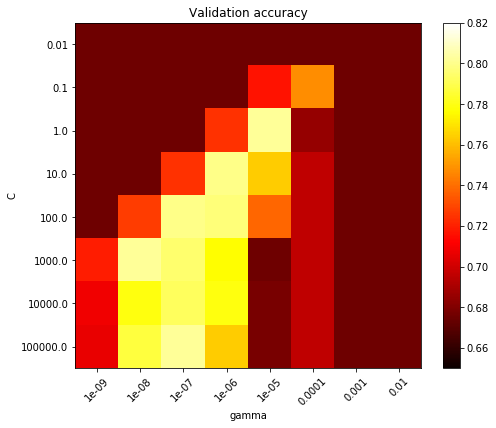

In [8]:
##from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
C_range = np.logspace(-2, 10, 8)
gamma_range = np.logspace(-9, 3, 8)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)


print("Searching for optimal parameters...")
grid.fit(X_test_scaled, np.ravel(Ytest))

##wow this is taking a while
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

##now lets plot a heat map of the options:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,vmin = .65,vmax= .82)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(8), np.logspace(-9,-2,8), rotation=45)
plt.yticks(np.arange(8),np.logspace(-2,5,8))
plt.title('Validation accuracy')
plt.show()

training...


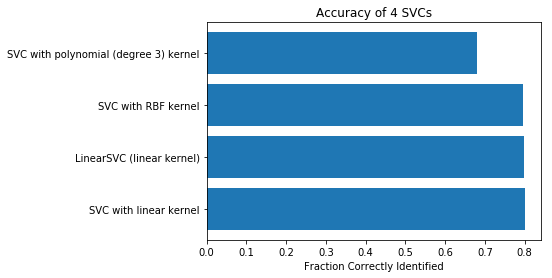

In [3]:
##first try SVM and report accuracy of different kernels and SVM methods
##divide the dataset in half for training and testing and divide into length 8 vectors for testing
X_train = np.asarray(data.loc[:int(len(data)/2),data.columns!='Class'])
X_train = np.c_[X_train]
##normalize the data
##create a scaler that we can also use for the test data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

##now make the y training data  
Ytrain = np.asarray(data.loc[:int(len(data)/2),data.columns =='Class'])
Ytrain = np.c_[Ytrain]

##make x and y training data
X_test = data.loc[int(len(data)/2):, data.columns!='Class']
X_test = np.c_[X_test]
X_test_scaled = scaler.transform(X_test)
Ytest = data.loc[int(len(data)/2):, data.columns =='Class']
Ytest = np.c_[Ytest]

##Lets first try SVC with linear kernel
##write function that plots accuracies
def acc_plot(models,titles,label):
    print ("training...")
    model_fit = (clf.fit(X_train_scaled, np.ravel(Ytrain)) for clf in models)
    acc = (clf.score(X_test_scaled,Ytest) for clf in model_fit)
    score = [sc for sc in acc]
    fig, ax = plt.subplots()
    ax.barh(range(len(score)),score)
    ax.set_xlabel('Fraction Correctly Identified')
    ax.set_title(label)
    ax.set_yticks(range(len(score)))
    ax.set_yticklabels(titles)
    
    
    
    
C = 1.0
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=1e5),
          svm.SVC(kernel='rbf', gamma=.007, C=26.8),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=1e-4,max_iter=1e8))
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

acc_plot(models,titles,"Accuracy of 4 SVCs")

## Logistic Regression
I experiment with three different Logistic Regression models with three different penalty functions. The Elastic Net penalty uses both L1 and L2 norms. I also experiment with Logistic Regression with built-in cross-validation but results are nearly identical.
The highest coefficients correspond to BMI and diabetes pedigree function. With scaled data, this is an indication that these two factors have a greater influence on likelihood of testing positive than other measures of health. All coefficients are postive, meaning an increase in any of these measures increases the chance of testing postive.

training...
training...
[[1.30975223 1.942513   0.93207722 0.97876104 0.96820663 1.61393842
  1.35791188 1.1859155 ]]
[0.53393258]


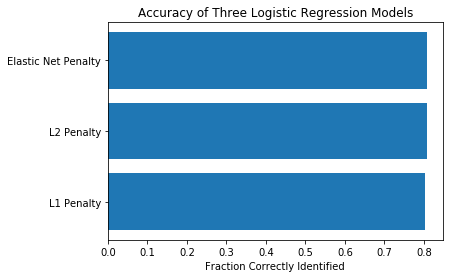

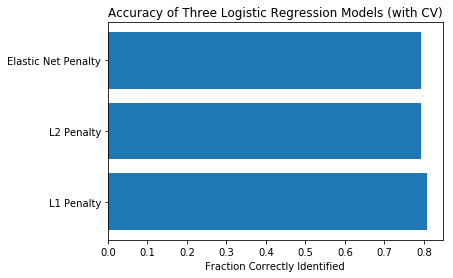

In [4]:
from sklearn.linear_model import LogisticRegression as LR

log_models = (LR(penalty='l1'),LR(penalty = 'l2'),LR(penalty='elastic net',solver = 'saga'))


log_titles = ('L1 Penalty','L2 Penalty','Elastic Net Penalty')

acc_plot(log_models,log_titles,"Accuracy of Three Logistic Regression Models")


##see effect of regularization. See if we can improve each model with better c
##uses stratified k-folds for cross-validation
from sklearn.linear_model import LogisticRegressionCV as LRCV
log_cv = (LRCV(penalty='l1',random_state=0,solver='saga'),LRCV(penalty='l2',random_state=0),LRCV(penalty='elastic net',random_state=0,solver='saga'))


acc_plot(log_cv,log_titles,"Accuracy of Three Logistic Regression Models (with CV)")

##here lets check out the coefficients of the scaled data
model = LRCV().fit(X_train_scaled,np.ravel(Ytrain))
print(np.exp(model.coef_))
print(np.exp(model.intercept_))



##nope didnt help at all...

## Ridge Classifier
Next I try a Ridge Classifier with built-in cross validation. Ridge regression is converted to a classification problem by mapping the {0,1} outputs to {-1,1}. Ridge regression differs from ordinary regression in that it uses a penalty term to keep the size of coefficients in check. 

In [14]:
from sklearn.linear_model import RidgeClassifierCV
clf_ridge = RidgeClassifierCV().fit(X_train_scaled,np.ravel(Ytrain))
ridge_score = clf_ridge.score(X_test_scaled,Ytest)
print('The Ridge Classifier correctly predicted %s percent of test cases.' %(ridge_score*100).round(1))

The Ridge Classifier correctly predicted 79.4 percent of test cases.


## Neural Net Classifier
Lastly I try out the Multilayer Perceptron with three different activation functions: sigmoid, hyperbolic tangent, and linear rectified function (chooses max(0,x)).

training...


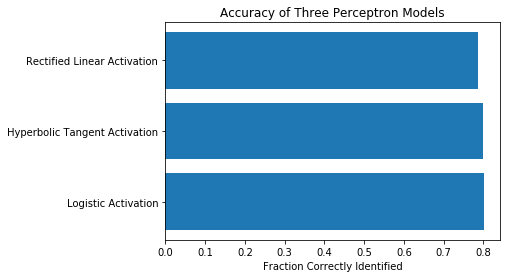

In [6]:
##lets try a Neural Net - multlayer perceptron
from sklearn.neural_network import MLPClassifier as MLP
MLP_models = (MLP(activation = 'logistic').fit(X_train_scaled,np.ravel(Ytrain)),
                  MLP(activation = 'tanh').fit(X_train_scaled,np.ravel(Ytrain)),
                MLP(activation = 'relu').fit(X_train_scaled,np.ravel(Ytrain) ))


titles = ('Logistic Activation','Hyperbolic Tangent Activation','Rectified Linear Activation')

acc_plot(MLP_models,titles,"Accuracy of Three Perceptron Models")

## Conclusion
Virtually all of the classifiers performed identically, getting around 80% of the test cases correct. About 35% of the samples were positive tests with variance of about .23. The lower bound of the error rate could be due to false positive or false negative tests.
The two purposes of this project were acheived: learn about classifiers in scikit and plotting with matplotlib. Future work on this project could include understanding the limits of the models and diving deeper into the math behind the classification techniques and solvers.